In [1]:
import os
import argparse
import pandas as pd
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import matplotlib.pyplot as plt
import seaborn as sns
from rdflib import Graph
import yaml

In [2]:
def load_config(config_path: str) -> dict:
    """Load a YAML config file"""

    with open(config_path, "r", encoding="utf-8") as file:
        config = yaml.safe_load(file)

    return config

In [3]:
# Function to convert turtle KG file to TSV
def turtle_to_tsv(input_file, output_file):
    # Load the Turtle file into an RDFLib Graph
    g = Graph()
    g.parse(input_file, format='turtle')

    # Open the TSV file for writing
    with open(output_file, 'w') as tsvfile:
        # Iterate over triples and write them to the TSV file
        for subj, pred, obj in g:
            tsvfile.write(f"{subj}\t{pred}\t{obj}\n")

In [4]:
# Generate TSV file from Turtle KG
input_file = 'input.ttl'  # Replace with your Turtle file path
output_file = 'output.tsv'  # Output TSV file path
turtle_to_tsv(input_file, output_file)

In [4]:
# Function to generate experiment name from experiment configuration - useful to saving artifacts
def generate_experiment_name(model_name, optimizer_name, loss_function, create_inverse):
    """Generate a unique experiment name based on the combination of parameters"""
    return f"{model_name}_{optimizer_name}_{loss_function}_{'with_inverse' if create_inverse else 'without_inverse'}"

In [5]:
# Fun to run experiments
def run_baseline(config: dict) -> None:
    """Run a Baseline Model With Default Parameters"""
    
    # Initialize an empty DataFrame to store experiment results
    experiment_results = pd.DataFrame(columns=['model', 'optimizer', 'loss', 'inverse', 'hits@10'])

    for model in config["models"]:
        for optimizer in config["optimizers"]:
            for loss_function in config["training"]["loss_function"]:
                for create_inverse in config["training"]["create_inverse"]:
                    experiment_name = generate_experiment_name(model["name"], optimizer["class"], loss_function, create_inverse)
                    experiment_path = os.path.join(config["save"]["path"], experiment_name)

                    tf = TriplesFactory.from_path('output.tsv', create_inverse_triples=create_inverse)
                    training, testing, validation = tf.split([.8, .1, .1])
                    
                    pipeline_result = pipeline(
                        training=training,
                        testing=testing,
                        validation=validation,
                        loss=loss_function,
                        model=model["name"],
                        model_kwargs={
                            "embedding_dim": model["embedding_dim"],
                            "random_seed": config["seed"],
                        },
                        training_loop="sLCWA",
                        training_kwargs={
                            "num_epochs": config["training"]["num_epoch"],
                        },
                        optimizer=optimizer["class"],
                        optimizer_kwargs={"lr": optimizer["lr"]},
                        negative_sampler_kwargs={
                            "num_negs_per_pos": config["training"]["num_negative"],
                        },
                        random_seed=config["seed"],
                        evaluator_kwargs={"filtered": True},
                        use_testing_data=False,
                        use_tqdm=False
                    )

                    # Save hits@10 to the DataFrame
                    experiment_results = experiment_results.append({
                        'model': model["name"],
                        'optimizer': optimizer["class"],
                        'loss': loss_function,
                        'inverse': 'with_inverse' if create_inverse else 'without_inverse',
                        'hits@1': pipeline_result.get_metric("hits_at_1"),
                        'hits@3': pipeline_result.get_metric("hits_at_3"),
                        'hits@5': pipeline_result.get_metric("hits_at_5"),
                        'hits@10': pipeline_result.get_metric("hits_at_10"),
                    }, ignore_index=True)

                    pipeline_result.save_to_directory(experiment_path)

    # Export experiment results to CSV file
    experiment_results.to_csv(os.path.join(config["save"]["path"], 'experiment_results.csv'), index=False)


In [8]:
# Directly assign the path to your YAML configuration file here
config_path = './config.yaml'

run_config = load_config(config_path)

assert run_config["type"] == "baseline", "Incorrect Config Type"

for dataset in run_config["datasets"]:
    run_config["dataset"] = dataset  # Update dataset for each run
    run_baseline(run_config)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1318, 377, 378]
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.
INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=1739, num_relations=9, num_triples=3019, inverse_triples=False, path="/home/jovyan/workspace/soda/soda-training-setup/output.tsv") to file:///home/jovyan/workspace/soda/soda-training-setup/results/RotatE_Adam_NSSALoss_without_inverse/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/jovyan/workspace/soda/soda-training-setup/results/RotatE_Adam_NSSALoss_without_inverse


In [12]:
experiment_results = pd.read_csv('./results/experiment_results.csv')

In [13]:
melted_data = experiment_results.melt(
                      id_vars=['model', 'optimizer', 'loss', 'inverse'],  # Keep these columns as identifiers
                      value_vars=['hits@1', 'hits@3', 'hits@5', 'hits@10'],  # These columns will be "melted"
                      var_name='metric',  # Name of the new column that holds the name of the melted columns
                      value_name='score')  # Name of the new column that holds the values of the melted columns

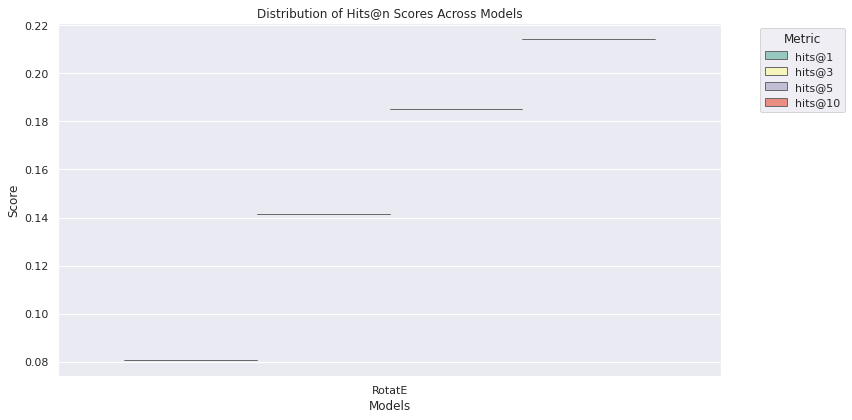

In [14]:
# Distribution of Hits@n Scores Across Models

plt.figure(figsize=(12, 6))  # Adjust size as needed

# Filter the data to include only Hits@10 scores
hits_10_data = melted_data[melted_data['metric'] == 'hits@10']

sns.set(style="darkgrid")

# Create a box plot
sns.boxplot(x='model', y='score', hue='metric', data=melted_data, palette='Set3')


plt.title('Distribution of Hits@n Scores Across Models')
plt.xlabel('Models')
plt.ylabel('Score')
# plt.xticks(rotation=45)  # Rotate model names for better readability

# Optional: Place the legend outside the plot
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

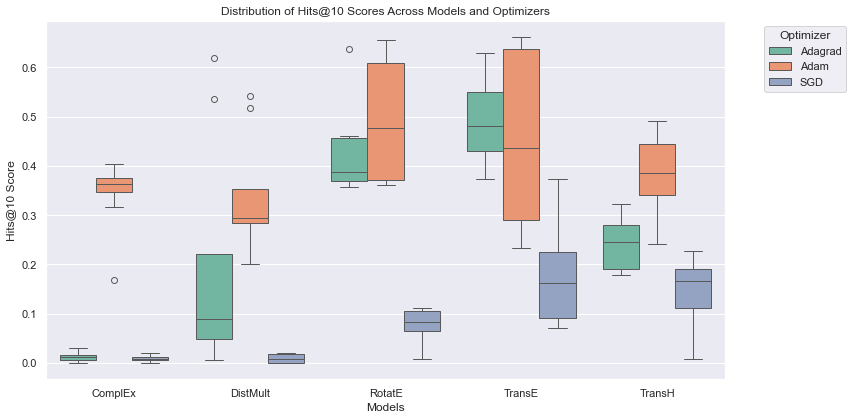

In [11]:
# Distribution of Hits@10 Scores Across Models and Optimizers

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Filter the data to include only Hits@10 scores
hits_10_data = melted_data[melted_data['metric'] == 'hits@10']

# Create the box plot
sns.boxplot(x='model', y='score', hue='optimizer', data=hits_10_data, palette='Set2')

plt.title('Distribution of Hits@10 Scores Across Models and Optimizers')
plt.xlabel('Models')
plt.ylabel('Hits@10 Score')

# Optional: Adjust the legend
plt.legend(title='Optimizer', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

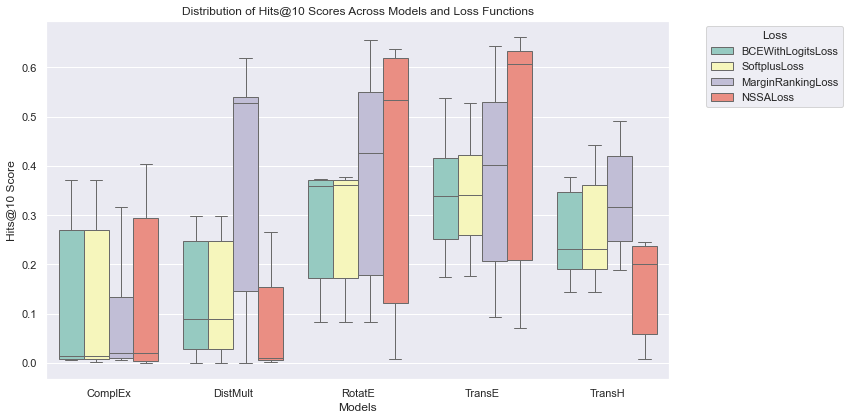

In [12]:
# Distribution of Hits@10 Scores Across Models and Optimizers

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Filter the data to include only Hits@10 scores
hits_10_data = melted_data[melted_data['metric'] == 'hits@10']

# Create the box plot
sns.boxplot(x='model', y='score', hue='loss', data=hits_10_data, palette='Set3')

plt.title('Distribution of Hits@10 Scores Across Models and Loss Functions')
plt.xlabel('Models')
plt.ylabel('Hits@10 Score')

# Optional: Adjust the legend
plt.legend(title='Loss', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

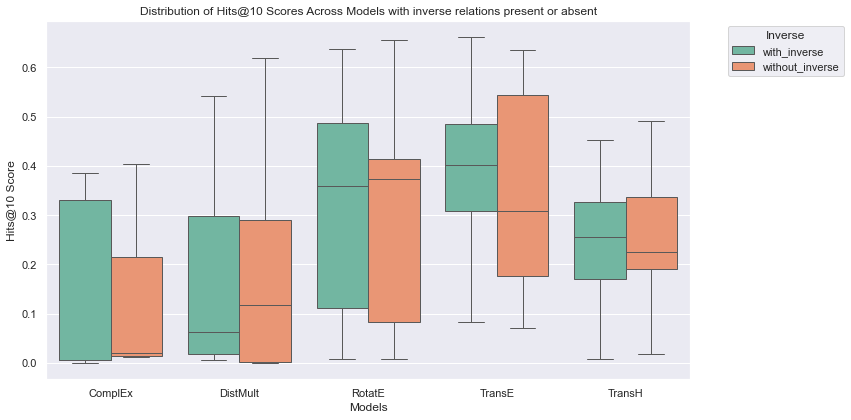

In [13]:
# Distribution of Hits@10 Scores Across Models with inverse relations present or absent

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Filter the data to include only Hits@10 scores
hits_10_data = melted_data[melted_data['metric'] == 'hits@10']

# Create the box plot
sns.boxplot(x='model', y='score', hue='inverse', data=hits_10_data, palette='Set2')

plt.title('Distribution of Hits@10 Scores Across Models with inverse relations present or absent')
plt.xlabel('Models')
plt.ylabel('Hits@10 Score')

# Optional: Adjust the legend
plt.legend(title='Inverse', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [1]:
# TODO: Read this https://cthoyt.com/2020/12/11/inverse-triple-scoring.html